In [1]:
%pylab inline
%matplotlib inline

# Global Imports
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.font_manager import FontProperties
matplotlib.style.use('ggplot')

from wordcloud import WordCloud, STOPWORDS
from scipy.misc import imread

import numpy as np
import pandas as pd
import os
import sys
from pprint import pprint
from time import time
import datetime
from time import gmtime, strftime
import statsmodels.api as sm
from patsy import dmatrices

# Local Imports
path = str(os.path.expanduser('~')) + '/git/predictEPL/config'
sys.path.append(path)
import paths

sys.path.append(paths.UTILS)
import useful_methods
import hash_tags
import tokenizer

Populating the interactive namespace from numpy and matplotlib


In [2]:
# read df
df = useful_methods.csv_dic_df("/Users/Bya/Dropbox/Research/datas/EPL/tweet_numbers.csv")

# str num => int num
columns = list(df.columns)[3:] + [list(df.columns)[0]]
for index in columns:
    df[index] = [int(item) for item in df[index]]

dfHome = df[['GW', 'Team_home', 'all_home', 'filter_home', 'non_rt_home']]
dfHome.columns = ['gw', 'team', 'tweet', 'tweet_filter', 'tweet_non_rt']

dfAway = df[['GW', 'Team_away', 'all_away', 'filter_away', 'non_rt_away']]
dfAway.columns = ['gw', 'team', 'tweet', 'tweet_filter', 'tweet_non_rt']

df = dfHome.append(dfAway, ignore_index=True)

df = df.sort_values(['gw'], ascending=True).reset_index(drop=True)

## All Tweet Nums

In [3]:
# all team sum
df.tweet.sum()

2146897

In [16]:
# Team week sums
dfTeams = pd.DataFrame(columns=[u'team', u'tweet', 'tweet_filter', 'tweet_no_rt'])
for team in list(set(df.team)):
    dfTeams.loc[len(dfTeams) + 1] = [team] + list(df[df.team == team].sum())[2:]


dfTeams = dfTeams.sort_values(['team'], ascending=True).reset_index(drop=True)
dfTeams["game_num"] = [19, 19, 18, 19, 18, 19, 18, 19, 19, 19, 19, 19, 19, 19, 19, 18, 19, 17, 19, 19]
dfTeams["tweet_avg"] = dfTeams['tweet'] / dfTeams['game_num']

dfTeams = dfTeams.sort_values(['tweet_avg'], ascending=False).reset_index(drop=True)
dfTeams.index = range(1, 21)
dfTeams

,team,tweet,tweet_filter,tweet_no_rt,game_num,tweet_avg
1,United,693924,680883,247085,18,38551.333333
2,Liverpool,357391,339362,159752,19,18810.052632
3,Arsenal,224557,215839,108905,19,11818.789474
4,Chelsea,203525,196424,105379,18,11306.944444
5,City,133508,128423,40736,19,7026.736842
6,Tottenham,109924,106648,52117,19,5785.473684
7,Newcastle,92792,91039,54610,19,4883.789474
8,Villa,48710,47615,33201,19,2563.684211
9,Leicester,37833,36660,16225,18,2101.833333
10,Everton,36205,34662,24383,19,1905.526316


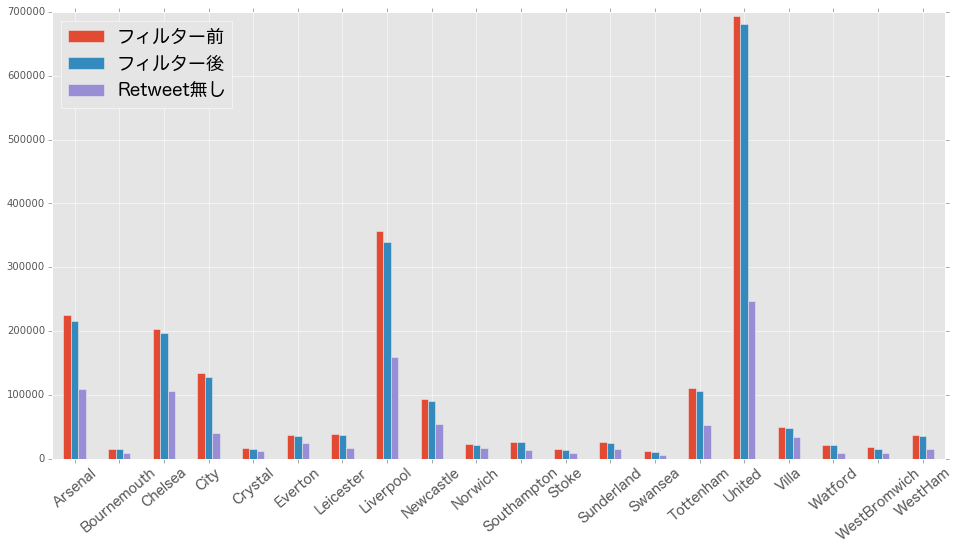

In [6]:
teams = list(dfTeams.team)

# Plot Histogram
ax = dfTeams.plot(kind='bar', stacked=False, figsize=(16, 8))

# font size set
fp_large = FontProperties(fname=r'/Library/Fonts/ヒラギノ丸ゴ ProN W4.ttc', size=18)
fp_normal = FontProperties(fname=r'/Library/Fonts/ヒラギノ丸ゴ ProN W4.ttc', size=14)
fp_small = FontProperties(fname=r'/Library/Fonts/ヒラギノ丸ゴ ProN W4.ttc', size=10)

# ax.set_xlabel('チーム名', fontproperties=fp_large)
# ax.set_ylabel('Tweet数', fontproperties=fp_large)
ax.set_xticklabels(teams, rotation=40, fontproperties=fp_normal)
ax.legend(['フィルター前', 'フィルター後', 'Retweet無し'], prop=fp_large, loc='upper left')

## Wordle me

In [145]:
def Wordle(text):
    twitter_mask = imread('/Users/Bya/git/predictEPL/Wordle/twitter_mask.png', flatten=True)
    
    wordcloud = WordCloud(background_color="white", \
                          width=900, \
                          height=500, \
#                           mask=twitter_mask\
                         ).generate(text)
    
    plt.figure(figsize=(15, 12))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [146]:
# Read Match and extract text
dfSingleMatch = useful_methods.SingleGameDf(13, 'City', 'Liverpool')

# Tokenize and remove stopwords
text_all = " ".join(list((dfSingleMatch.text)))
text_all = " ". join(tokenizer.LemmaNoSoccerStops(text_all))

/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


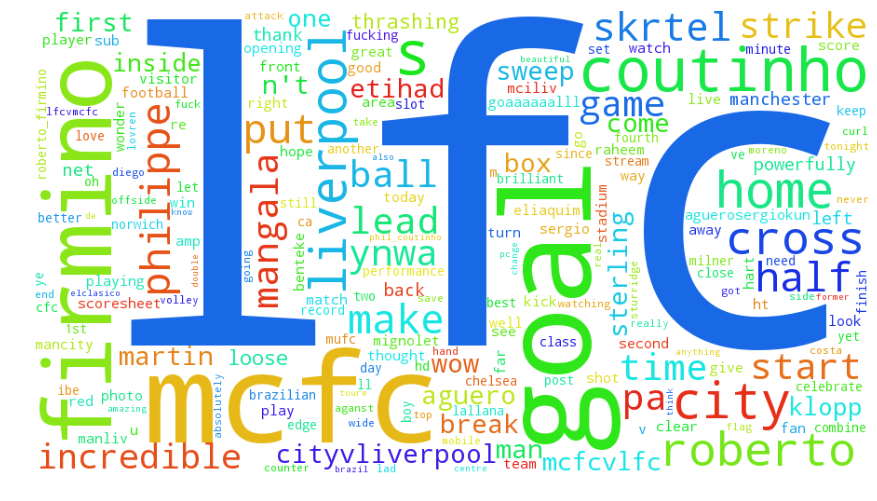

In [147]:
# Plot 
Wordle(text_all)

## Tweet and Review's text Histogram

Mean: 115.156255862, Std: 51.197144421


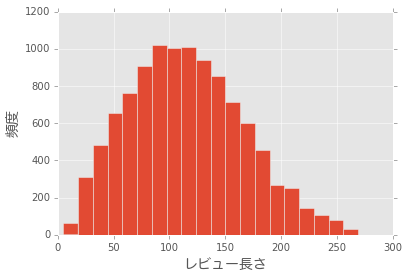

In [30]:
# read review data
dfReview = useful_methods.csv_dic_df("/Users/Bya/Dropbox/Research/datas/ShortReviews/short_movie_reviews.csv")

# convert label str num to int
dfReview.sentiment = [np.int(item) for item in dfReview.sentiment]

# add lenght column
dfReview['length'] = [np.int(len(text)) for text in dfReview.review]

# plot length review
ax = dfReview.length.plot(kind='hist', bins=20)
ax.set_ylabel("頻度", fontproperties=fp_normal)
ax.set_xlabel("レビュー長さ", fontproperties=fp_normal)


# mean, std
review_len = np.array(dfReview.length)
print("Mean: %s, Std: %s" % (review_len.mean(), review_len.std()))

Mean: 76.1173407497, Std: 43.4702027732


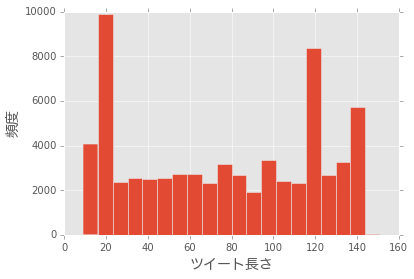

In [33]:
# Read Match and extract text
dfSingleMatch = useful_methods.SingleGameDf(13, 'City', 'Liverpool')

# add length column
dfSingleMatch['length'] = [np.int(len(text)) for text in dfSingleMatch.text]

# plot length tweet
ax = dfSingleMatch[
    (dfSingleMatch.status != 'quoted') &
    (dfSingleMatch.text_status == 'normal')].length.plot(kind='hist', bins=20)
ax.set_ylabel("頻度", fontproperties=fp_normal)
ax.set_xlabel("ツイート長さ", fontproperties=fp_normal)

# mean, std
tweet_len = np.array(dfSingleMatch[
    (dfSingleMatch.status != 'quoted') &
    (dfSingleMatch.text_status == 'normal')].length)
print("Mean: %s, Std: %s" % (tweet_len.mean(), tweet_len.std()))

### Graph plot

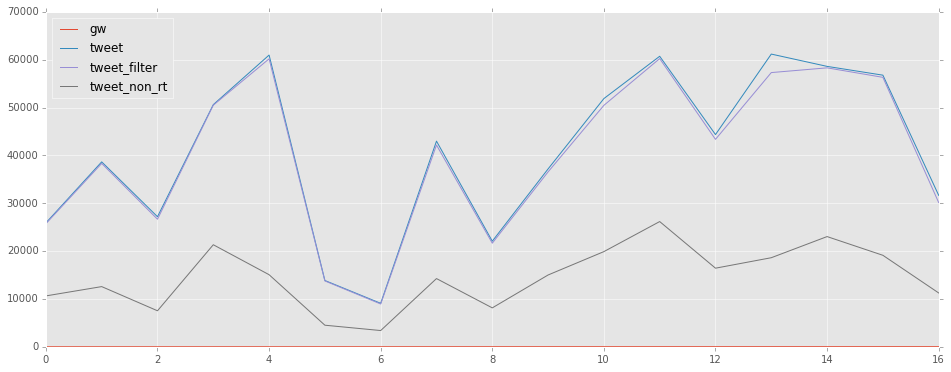

In [3]:
plt.figure(figsize=(16, 6))
df[df.team == 'United'].reset_index(drop=True).plot(figsize=(16, 6))

### Bar plot

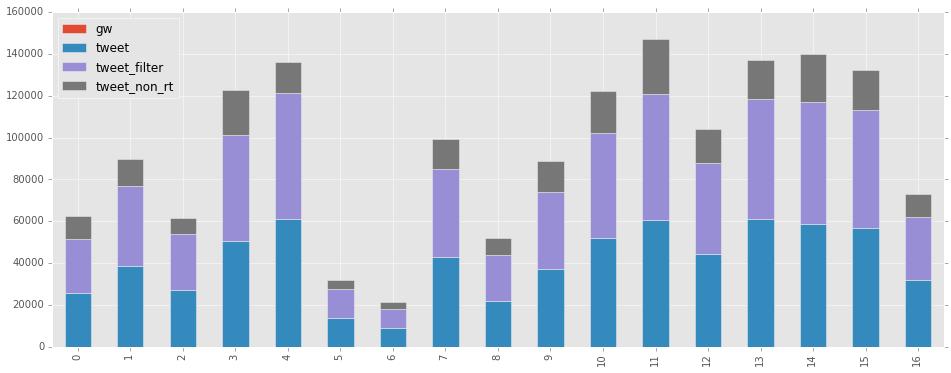

In [4]:
df[df.team == 'United'].reset_index(drop=True).plot(kind='bar', stacked=True, figsize=(16, 6))

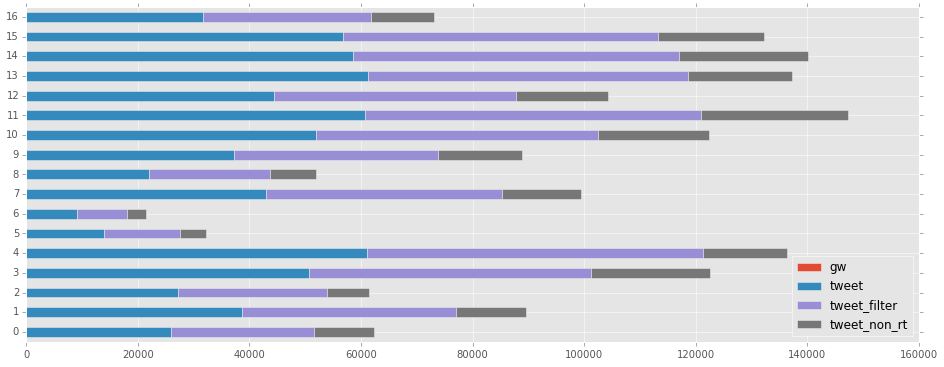

In [118]:
df[df.team == 'United'].reset_index(drop=True).plot(kind='barh', stacked=True, figsize=(16, 6))

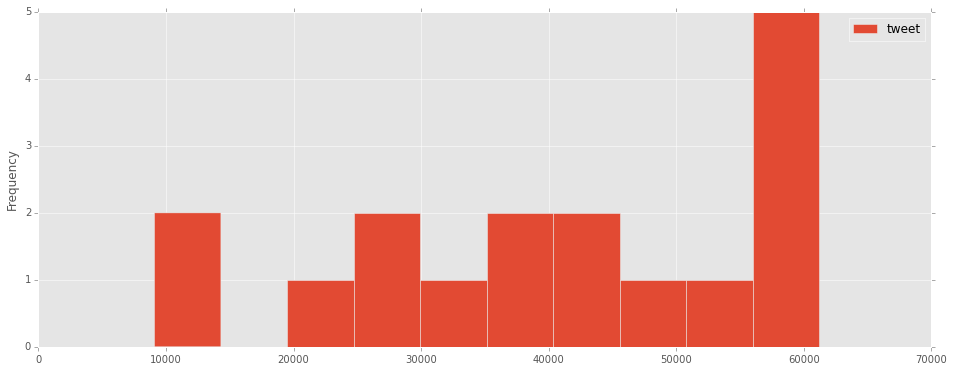

In [140]:
df[df.team == 'United'].reset_index(drop=True).plot(kind='hist', y='tweet', stacked=True, figsize=(16, 6))

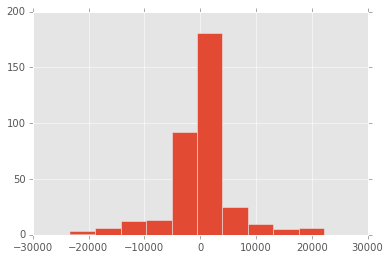

In [144]:
df['tweet_non_rt'].diff().hist()